In [9]:
import urllib.request
import json
import pandas as pd
import requests
import shutil
import os
from PIL import Image
import numpy
import math
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans



url = (
    "https://pixabay.com/api/?key=42732485-b4c1847a3529ea910e8e5fdeb&q=animaux&image_type=photo&per_page=100"
)
response = urllib.request.urlopen(url)
responsedata = json.loads(response.read().decode("utf-8"))
responsedata

def download_image(url):

    headers = {"User-Agent": "Mozilla/5.0"}
    request = requests.get(url, allow_redirects=True, headers=headers, stream=True)
    if request.status_code == 200:
        image_link = os.path.basename(url)
        filename = os.path.join("./images/", image_link)
        with open(filename, "wb") as image:
            request.raw.decode_content = True
            shutil.copyfileobj(request.raw, image)
    return request.status_code

array = []

for result in responsedata["hits"]:
    array.append(
        (
            result["id"],
            result["tags"],
            result["largeImageURL"],
            result["imageWidth"],
            result["imageHeight"],
            result["imageSize"],
            result["likes"], 
            result["user"],
            result["largeImageURL"].split('.')[-1]
        )
    )


dataframe = pd.DataFrame(array, columns=["id", "tags", "largeImageURL", "imageWidth","imageHeight","imageSize", "likes", "user", "format"])
dataframe = dataframe.astype(
    dtype={"id": "<U200", "tags": "<U200", "largeImageURL": "<U200","imageWidth": "<U200","imageHeight": "<U200","imageSize": "<U200", "likes": "<U200", "user": "<U200", "format": "<U200"}
)

# Color column
all_images=os.listdir("./images") #list of all the images' names
image_color=[] #list to add the images' color into the dataframe
dataframe['color']='None'
colorsOfAllImages=[] 
for i in range(len(all_images)):
    colorsOfOneImage="" #Reinitialization of the value of the colors
    color = [] #most significant colors of the images
    imgfile = Image.open("./images/"+all_images[i])
    numarray = numpy.array(imgfile.getdata(), numpy.uint8)
    if numarray.ndim == 1:
        imgfile = imgfile.convert('RGB')
        numarray = numpy.array(imgfile.getdata(), numpy.uint8)
    clusters = KMeans(n_clusters=4, n_init=2)
    clusters.fit(numarray)
    npbins = numpy.arange(0, 5)
    histogram = numpy.histogram(clusters.labels_, bins=npbins)
    labels = numpy.unique(clusters.labels_)
    for i in range(4):
        image_color=[math.ceil(clusters.cluster_centers_[i][0]),math.ceil(clusters.cluster_centers_[i][1]),math.ceil(clusters.cluster_centers_[i][2])]
        # Categorization
        for j in range(3):
            image_color[j] -= (image_color[j]) % 32
        color.append(image_color)
    colorsOfAllImages.append(color)
dataframe.loc[:,'color']=colorsOfAllImages

# Data type conversion to sort
# Int conversion
for int_column in ["id","imageWidth","imageHeight","imageSize","likes"]:
    dataframe[int_column] = dataframe[int_column].astype(int)
# "tags" conversion into list
new_tags = []
for i in range(len(dataframe["tags"])):
    new_tags.append(dataframe.loc[i, "tags"].replace(" ","").split(','))
dataframe['tags']=new_tags
    
    
    
# imageSize Categorization
dataframe["imageSize"] -= dataframe["imageSize"] % 500000 
for i in range(len(dataframe["imageSize"])):
    if dataframe.loc[i, "imageSize"] > 2000000:
        dataframe.loc[i, "imageSize"] = 2000000
dataframe



# Json conversion, Storage
json_data = dataframe.to_json(orient='records', indent = 4)
file_path = "data.json"
with open(file_path, "w") as json_file:
    json_file.write(json_data)

# Read test for the json produced
readtest_data = json.load(open("data.json"))
readtest_dataframe = pd.json_normalize(readtest_data)
readtest_dataframe

,id,tags,largeImageURL,imageWidth,imageHeight,imageSize,likes,user,format,color
0,715588,"[fox, nature, animals]",https://pixabay.com/get/g6c539a02192e0c7894e32...,3595,2414,2000000,1513,AlainAudet,jpg,"[[0, 0, 0], [96, 96, 64], [160, 160, 160], [64..."
1,430441,"[horses, galloping, running]",https://pixabay.com/get/g1993fb60f6b74fa3ca91f...,4500,3000,1000000,1522,SorcerySoapHP,jpg,"[[160, 128, 96], [96, 96, 64], [64, 32, 0], [1..."
2,591359,"[tigers, cub, snow]",https://pixabay.com/get/gdc01dee992e6ecc9ca45a...,4342,2798,2000000,1746,Sponchia,jpg,"[[160, 192, 224], [0, 32, 32], [96, 128, 160],..."
3,2904536,"[horses, pair, wildhorses]",https://pixabay.com/get/gd4c57a4ac65552667440c...,4000,3000,2000000,1590,susannp4,jpg,"[[192, 192, 192], [96, 128, 128], [160, 192, 1..."
4,2934720,"[cat, kitten, pets]",https://pixabay.com/get/gae002fe38ec88d2abb1c6...,3495,2330,1500000,1549,Kirgiz03,jpg,"[[128, 64, 32], [192, 160, 128], [32, 32, 0], ..."
...,...,...,...,...,...,...,...,...,...,...
95,2222908,"[giraffe, head, ossicones]",https://pixabay.com/get/g890a508f7240c30896456...,4000,2669,2000000,690,Alexas_Fotos,jpg,"[[128, 96, 64], [32, 32, 0], [192, 160, 128], ..."
96,2045655,"[eagle, portrait, wild]",https://pixabay.com/get/g8d705a76e3e1470578847...,2066,2426,1000000,852,Robert_C,jpg,"[[128, 128, 128], [0, 32, 32], [192, 192, 192]..."
97,1869337,"[dolphins, mammals, animals]",https://pixabay.com/get/g6e15c1a5aedd640247b7e...,3840,2160,500000,388,Pexels,jpg,"[[32, 64, 0], [96, 128, 96], [64, 160, 0], [16..."
98,2107052,"[swan, water, white]",https://pixabay.com/get/gc8b2dc6fa808ce1ba7edc...,4000,2289,1000000,1277,NoName_13,jpg,"[[224, 224, 224], [0, 0, 0], [128, 128, 128], ..."


On va stocker id, tags, largeImageURL, imageWidth, imageHeight, imageSize, likes, format de l'image en prenant ce qu'il y a après le .; user

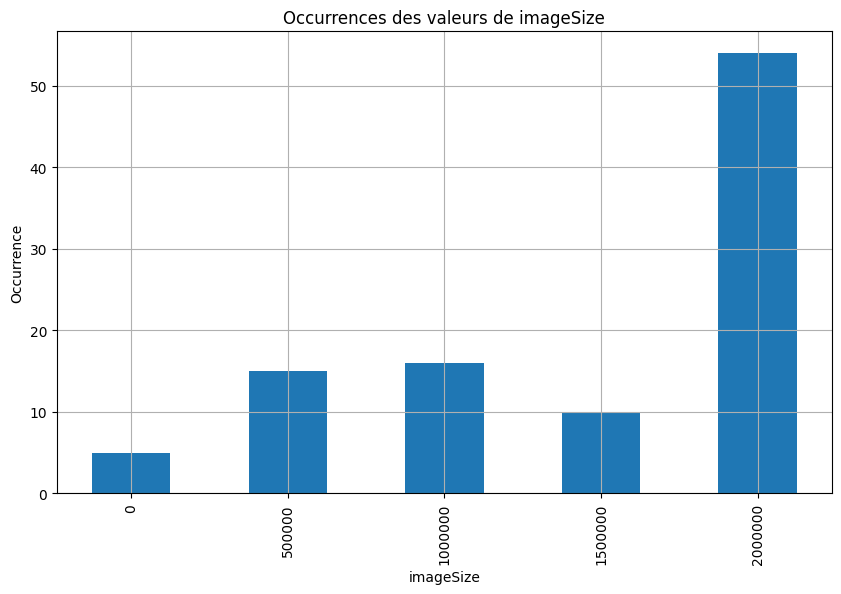

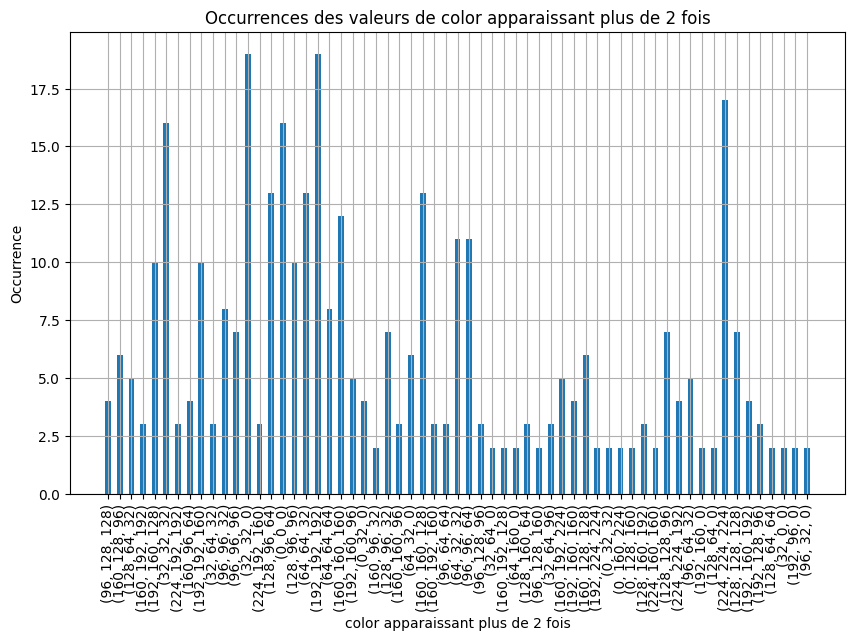

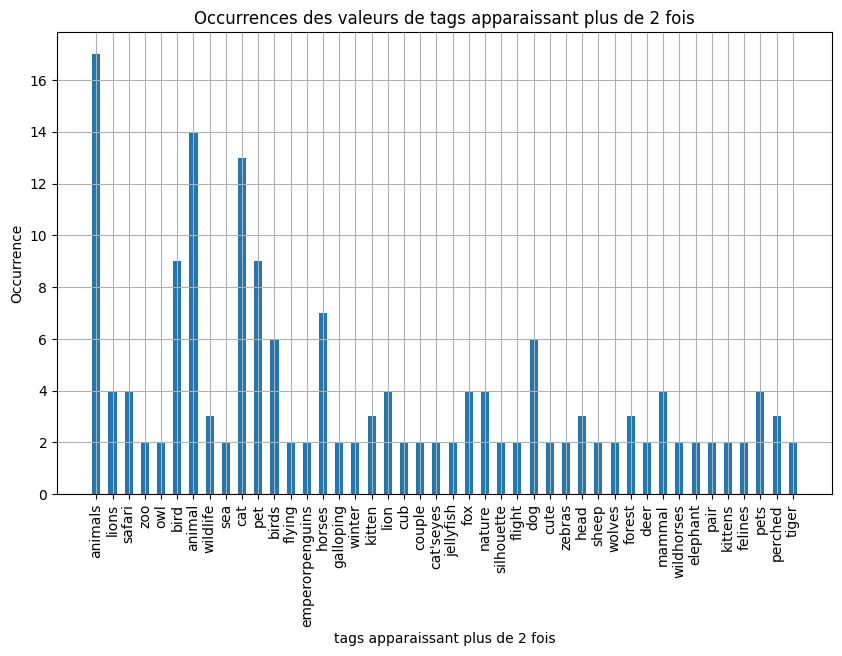

In [38]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Loads json
data = json.load(open("data.json"))
dataframe = pd.json_normalize(data)
#dataframe



# Sort
sort_key = input("Sort by : \n id / imageWidth / imageHeight / imageSize / color / likes ")
dataframe = dataframe.sort_values(by=sort_key)
# Json conversion, Storage
json_data = dataframe.to_json(orient='records', indent = 4)
file_path = "data.json"
with open(file_path, "w") as json_file:
    json_file.write(json_data)



# Occurrences
def occurrences(column, isColor = False):
    res = {}
    for value in dataframe[column]:
        if isinstance(value, list): # List case
            for element in value:
                if isColor : # color case
                    element = tuple(element)
                if element in res:
                    res[element] += 1
                else:
                    res[element] = 1
        else: # Single element case
            if value in res:
                res[value] += 1
            else:
                res[value] = 1
    return res
        

def visu_plot(name, data, bar_width=0.5):
    plt.figure(figsize=(10, 6))  # Taille de la figure

    keys = [str(key) for key in data.keys()]
    #keys = list(data.keys())
    values = list(data.values())
    plt.bar(keys, values, width=bar_width)

    # Ajout de titre et de labels
    plt.title('Occurrences des valeurs de ' + name)
    plt.xlabel(name)
    plt.xticks(rotation=90)
    plt.ylabel('Occurrence')

    # Affichage du graphique
    plt.grid(True)  # Afficher la grille
    plt.show()



visu_plot("imageSize",dict(sorted(occurrences("imageSize").items())))

reduced_color_occurrences = {key: value for key, value in occurrences("color",True).items() if value > 1}
visu_plot("color apparaissant plus de 2 fois",reduced_color_occurrences)

reduced_tag_occurrences = {key: value for key, value in occurrences("tags").items() if value > 1}
visu_plot("tags apparaissant plus de 2 fois",reduced_tag_occurrences)
